
# IRIS VQC - Blind Quantum Computing

(Versão Binária)
Este notebook executa o código de Blind Quantum Computing utilizando Qiskit,  O objetivo é demonstrar como rodar experimentos quânticos de forma segura e privada, utilizando machine learning (aplicando **QNN (EstimatorQNN)** com um **classificador VQC**) com o dataset de exemplo (Iris).

Inclui:
- Pré-processamento do Iris (binário: *Setosa vs. Versicolor*)
- Construção do circuito (Feature Map + Ansatz)
- Treinamento do VQC com **ADAM**
- Envio do circuito por época
- Métricas finais e matriz de confusão

In [150]:
# Instalar dependências
!pip install qiskit qiskit-aer qiskit-machine-learning qiskit-algorithms scikit-learn numpy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [151]:
# instalar as bibliotecas necessárias

import os
import random
import numpy as np
import collections
import matplotlib
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit_algorithms.optimizers import ADAM

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import itertools

from quantumnet.components import Network, Logger

%matplotlib inline

# Controle de Aleatoriedade e Reprodutibilidade
O trecho abaixo define uma semente fixa (SEED = 42) e a aplica nas bibliotecas random, numpy e torch. Isso garante que os resultados aleatórios (como inicialização de pesos e embaralhamento de dados) sejam os mesmos a cada execução do código, o que é essencial para fins de reprodutibilidade. 

Além disso, o uso de torch.use_deterministic_algorithms(True) força o PyTorch a utilizar apenas algoritmos determinísticos, evitando variações internas e tornando os experimentos mais consistentes e confiáveis.

In [152]:

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Backend com Ruído

In [153]:
noise_model = NoiseModel()
error_1q = depolarizing_error(0.001, 1)
error_2q = depolarizing_error(0.002, 2)
noise_model.add_all_qubit_quantum_error(error_1q, ['h','x','y','rx','ry','rz'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

simulator = AerSimulator(noise_model=noise_model, shots=1024)

estimator = Estimator(options={
    "backend": simulator,
    "resilience_level": 1,
    "approximation": True
})

/tmp/ipykernel_12445/3980392373.py:9: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={


# Callback: envio do circuito por época
e outras funções

In [ ]:

def enviar_circuito_por_epoca(circuito, epoch, num_qubits, circuit_depth):
    print(f"[Epoch {epoch+1}] Enviando circuito para a rede...")
    try:
        rede.application_layer.run_app(
            "AC_BQC",
            alice_id=6,
            bob_id=0,
            num_qubits=num_qubits,
            scenario=2,
            circuit_depth=circuit_depth,
            circuito=circuito
        )
        print(f"[Epoch {epoch+1}] Envio concluído.")
    except Exception as e:
        print(f"[Epoch {epoch+1}] Erro ao enviar circuito: {str(e)}")

def plot_confusion_matrix(y_true, y_pred, class_names=None):

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Cria a visualização manualmente
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plota a matriz como imagem
    cax = ax.matshow(cm, cmap='Blues', alpha=0.8)
    fig.colorbar(cax)
    
    # Adiciona os valores nas células
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), 
                   ha='center', va='center', 
                   fontsize=16, fontweight='bold',
                   color='white' if cm[i, j] > cm.max()/2 else 'black')
    
    # Configura os eixos
    if class_names is not None:
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)
    
    ax.set_xlabel('Previsto', fontsize=12)
    ax.set_ylabel('Real', fontsize=12)
    ax.xaxis.set_label_position('top')
    
    plt.title('Matriz de Confusão - Classificador Quântico', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    return cm


# Inicializar a rede

In [155]:

rede = Network()
rede.set_ready_topology('grade', 8, 3, 3)
Logger.activate(Logger)
print("Rede pronta.")


2025-08-24 16:08:58,022: Host 0 inicializado com 0 qubits.
2025-08-24 16:08:58,023: Host 1 inicializado com 0 qubits.
2025-08-24 16:08:58,024: Host 2 inicializado com 0 qubits.
2025-08-24 16:08:58,024: Host 3 inicializado com 0 qubits.
2025-08-24 16:08:58,025: Host 4 inicializado com 0 qubits.
2025-08-24 16:08:58,025: Host 5 inicializado com 0 qubits.
2025-08-24 16:08:58,026: Host 6 inicializado com 0 qubits.
2025-08-24 16:08:58,027: Host 7 inicializado com 0 qubits.
2025-08-24 16:08:58,028: Host 8 inicializado com 0 qubits.
2025-08-24 16:08:58,028: Par EPR <quantumnet.objects.epr.Epr object at 0x7d57e45d1d90> adicionado ao canal.
2025-08-24 16:08:58,029: Par EPR <quantumnet.objects.epr.Epr object at 0x7d57e50f8b00> adicionado ao canal.
2025-08-24 16:08:58,030: Par EPR <quantumnet.objects.epr.Epr object at 0x7d57d6ef3b60> adicionado ao canal.
2025-08-24 16:08:58,031: Par EPR <quantumnet.objects.epr.Epr object at 0x7d57e50fb560> adicionado ao canal.
2025-08-24 16:08:58,031: Par EPR <qua

Hosts inicializados
Canais inicializados
Pares EPRs adicionados
Rede pronta.


# Carrega o conjunto de dados Iris
- X → dados (características/features) 
- y → rótulos (classes/labels)ris (binário)

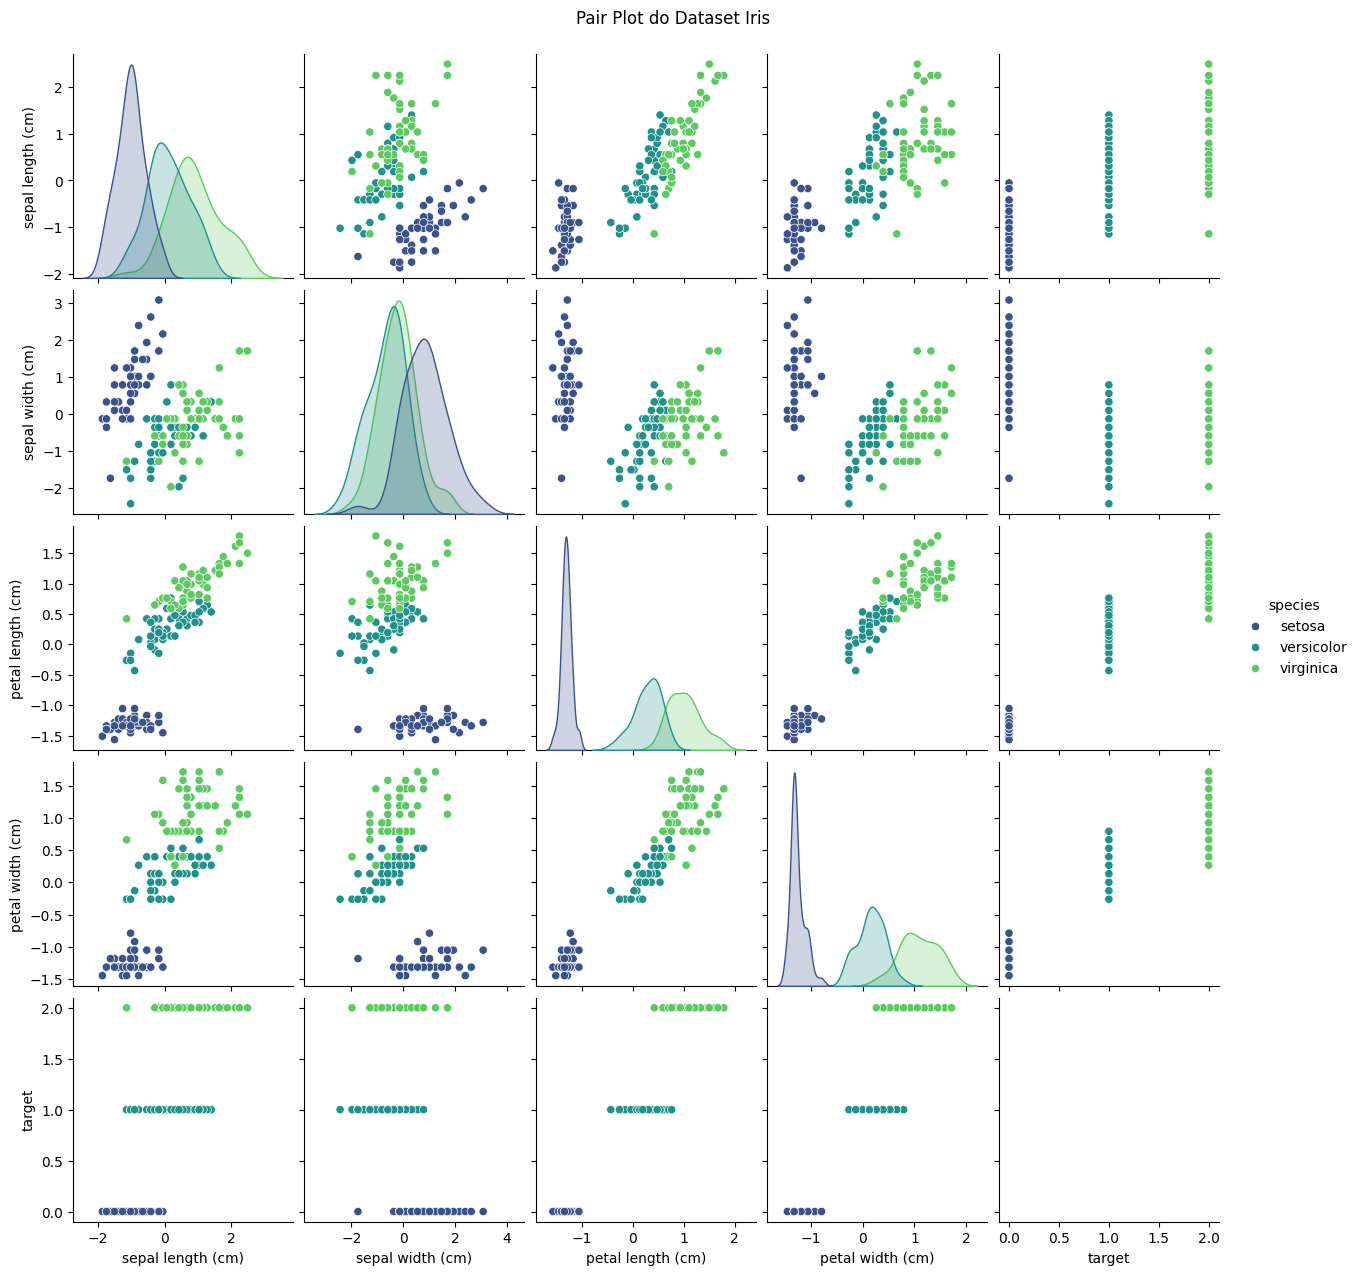

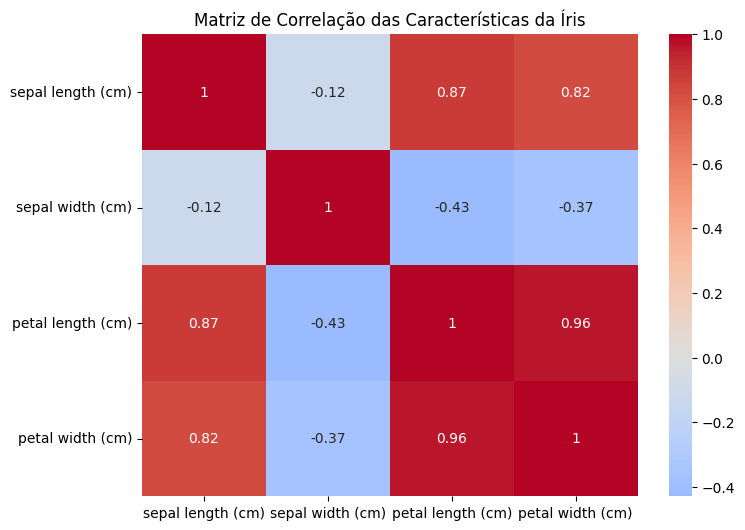

In [ ]:

iris = load_iris()
X = iris.data
y = iris.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:

# Criar um DataFrame para facilitar a visualização
df = pd.DataFrame(X, columns=iris.feature_names)#
df['target'] = y#
df['species'] = df['target'].apply(lambda i: iris.target_names[i])#

# Criar o Pair Plot
sns.pairplot(df, hue='species', palette='viridis', height=2.5)#
plt.suptitle('Pair Plot do Dataset Iris', y=1.02)#
plt.show()#

plt.figure(figsize=(8, 6))#
correlation_matrix = df[iris.feature_names].corr()#
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)#
plt.title('Matriz de Correlação das Características da Íris')#
plt.show()#

# Reduz para duas classes (binário)

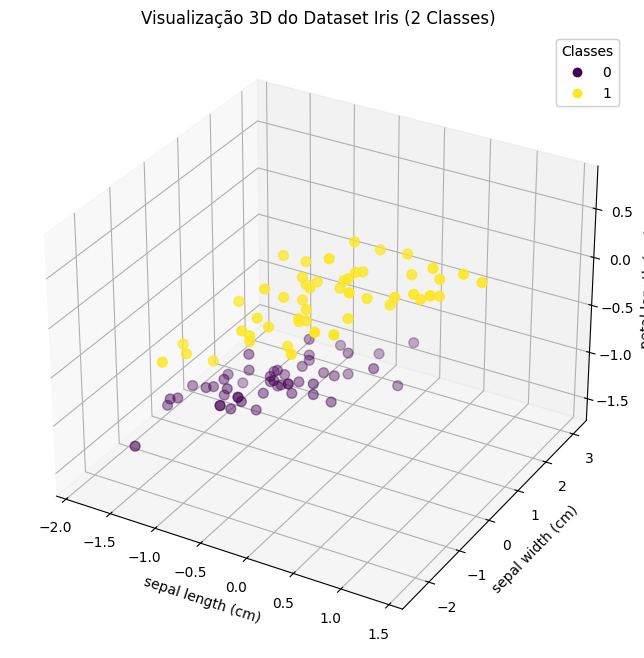

In [ ]:

X = X[y < 2]
y = y[y < 2]



In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
                     c=y, cmap='viridis', s=50)

ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
ax.set_zlabel(iris.feature_names[2])
ax.set_title('Visualização 3D do Dataset Iris (2 Classes)')

legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.show()

# Divide os dados 
80% treino e 20% teste


In [158]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
print("Distribuição das classes no y_train e y_test:")
print("Treino:", collections.Counter(y_train))
print("Teste:", collections.Counter(y_test))

Distribuição das classes no y_train e y_test:
Treino: Counter({np.int64(1): 42, np.int64(0): 38})
Teste: Counter({np.int64(0): 12, np.int64(1): 8})


# Cria o circuito quântico (FeatureMap + Ansatz)

In [159]:

num_qubits = 4
feature_map = ZZFeatureMap(num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=3)

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# EstimatorQNN 

In [160]:

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
    input_gradients=True
)


/tmp/ipykernel_12445/1341277591.py:1: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


# Treinamento

In [161]:

print("\nTREINANDO VQC...")

vqc = NeuralNetworkClassifier(
    neural_network=qnn,
    loss=CrossEntropyLoss(),
    optimizer=ADAM(maxiter=25),
    callback=lambda weights, loss, step: enviar_circuito_por_epoca(
        circuito=feature_map.compose(ansatz.assign_parameters(weights)),
        epoch=step,
        num_qubits=num_qubits,
        circuit_depth=feature_map.compose(ansatz).depth()
    )
)

vqc.fit(X_train, y_train)
print("Treinamento concluído.")



TREINANDO VQC...
Treinamento concluído.


# Avaliação: métricas


CALCULANDO MÉTRICAS...
Previsões: [1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0]
Reais:     [1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0]
Acertos:   8 / 20

GERANDO MATRIZ DE CONFUSÃO...


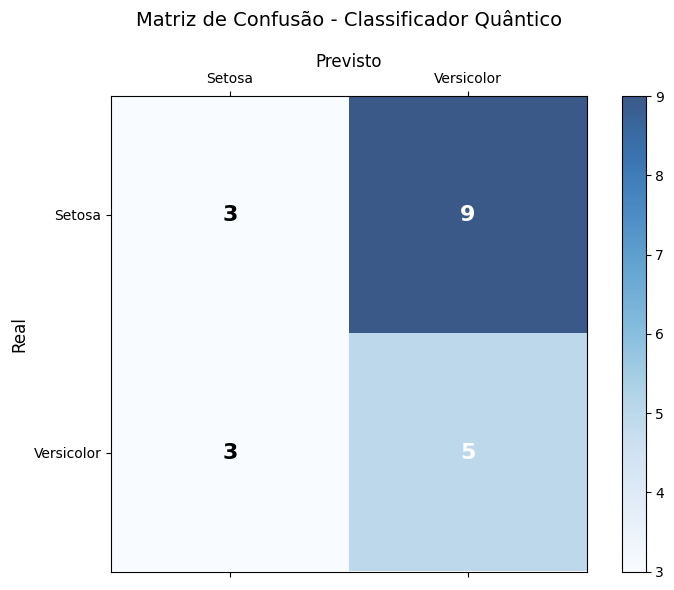


MÉTRICAS FINAIS:
Acurácia : 0.3000
Precisão : 0.1846
Recall   : 0.3000
F1 Score : 0.2286


In [ ]:
print("\nCALCULANDO MÉTRICAS...")
y_pred = vqc.predict(X_test)

y_pred = np.array(y_pred).flatten()  
y_pred = np.where(y_pred > 0.5, 1, 0)  

y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

print("Previsões:", y_pred)
print("Reais:    ", y_test)
print("Acertos:  ", sum(y_pred == y_test), "/", len(y_test))

#print("\nCALCULANDO MÉTRICAS...")
#y_pred = vqc.predict(X_test)

#y_test_int = y_test.astype(int)
#y_pred_int = y_pred.astype(int)

print("\nGERANDO MATRIZ DE CONFUSÃO...")
cm = plot_confusion_matrix(y_test, y_pred, class_names=['Setosa', 'Versicolor'])

accuracy = accuracy_score(y_test_int, y_pred_int)
precision = precision_score(y_test_int, y_pred_int, average='weighted', zero_division=0)
recall = recall_score(y_test_int, y_pred_int, average='weighted', zero_division=0)
f1 = f1_score(y_test_int, y_pred_int, average='weighted', zero_division=0)

print("\nMÉTRICAS FINAIS:")
print(f"Acurácia : {accuracy:.4f}")
print(f"Precisão : {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

In [163]:
print("Previsões do modelo:", y_pred)
print("Valores reais:      ", y_test)
print("Acertos/Erros:      ", y_pred == y_test)

Previsões do modelo: [1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0]
Valores reais:       [1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0]
Acertos/Erros:       [ True  True False False False False False  True  True False False  True
  True False False False  True False False  True]


Gráfico

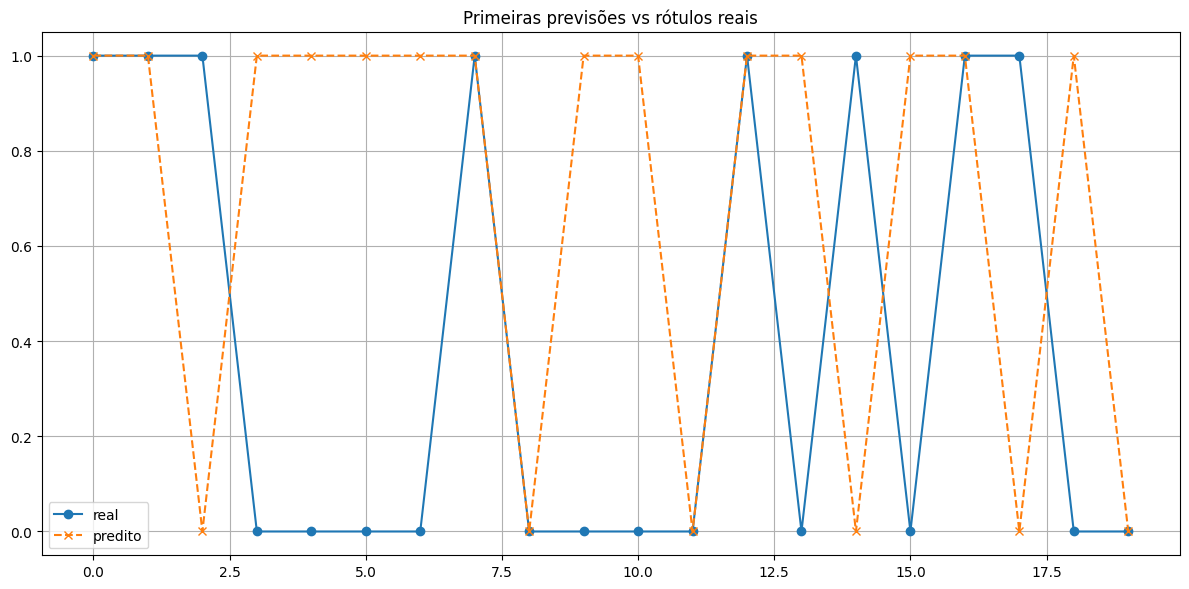

In [166]:
plt.figure(figsize=(12,6))
plt.title('Primeiras previsões vs rótulos reais')
plt.plot(y_test, marker='o', label='real')
plt.plot(y_pred, marker='x', linestyle='--', label='predito')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()